In [1]:
# dataset from https://www.kaggle.com/datasets/hojjatk/mnist-dataset?resource=download
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from array import array

In [2]:
train_images_path = "data/train-images.idx3-ubyte"
train_labels_path = "data/train-labels.idx1-ubyte"
test_images_path = "data/t10k-images.idx3-ubyte"
test_labels_path = "data/t10k-labels.idx1-ubyte"

In [3]:
def load_dataset(images_path, labels_path):
  with open(images_path, "rb") as f:
    magic = int(f.read(4).hex(), 16)
    num_images = int(f.read(4).hex(), 16)
    num_rows = int(f.read(4).hex(), 16)
    num_columns = int(f.read(4).hex(), 16)
    img_data = array("B", f.read())
  
  with open(labels_path, "rb") as f:
    magic = int(f.read(4).hex(), 16)
    num_labels = int(f.read(4).hex(), 16)
    label_data = array("B", f.read())
  
  images = np.zeros((num_images, num_rows, num_columns), dtype=np.uint8)
  labels = np.zeros(num_labels, dtype=np.uint8)

  assert num_images == num_labels, "Number of images and labels do not match"

  for i in range(num_images):
    images[i] = np.array(img_data[i*num_rows*num_columns:(i+1)*num_rows*num_columns]).reshape(num_rows, num_columns)
    labels[i] = label_data[i]
  
  return images, labels


In [4]:
train_images, train_labels = load_dataset(train_images_path, train_labels_path)
test_images, test_labels = load_dataset(test_images_path, test_labels_path)

print(f"Training data shape: {train_images.shape}, {train_labels.shape}")
print(f"Test data shape: {test_images.shape}, {test_labels.shape}")

Training data shape: (60000, 28, 28), (60000,)
Test data shape: (10000, 28, 28), (10000,)


In [5]:
# Preprocess the data
# Reshape images to vectors and normalize pixel values to [0, 1]
def preprocess_data(images, labels):
    # Reshape each image from 28x28 to a 784 vector
    X = images.reshape(images.shape[0], -1).astype('float32') / 255.0
    
    # One-hot encode the labels
    y = np.zeros((labels.shape[0], 10))
    for i, label in enumerate(labels):
        y[i, label] = 1.0
        
    return X, y

X_train, y_train = preprocess_data(train_images, train_labels)
X_test, y_test = preprocess_data(test_images, test_labels)

print(f"Processed training data shape: {X_train.shape}, {y_train.shape}")
print(f"Processed test data shape: {X_test.shape}, {y_test.shape}")

Processed training data shape: (60000, 784), (60000, 10)
Processed test data shape: (10000, 784), (10000, 10)


In [6]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
        self.b2 = np.zeros((1, output_size))
        
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def softmax(self, x):
        exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2
    
    def backward(self, X, y, output, learning_rate):
        batch_size = X.shape[0]

        delta_output = output - y
        dW2 = np.dot(self.a1.T, delta_output) / batch_size
        db2 = np.sum(delta_output, axis=0, keepdims=True) / batch_size
        
        delta_hidden = np.dot(delta_output, self.W2.T) * self.sigmoid_derivative(self.a1)
        dW1 = np.dot(X.T, delta_hidden) / batch_size
        db1 = np.sum(delta_hidden, axis=0, keepdims=True) / batch_size
        
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
    
    def compute_loss(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
        return loss
    
    def predict(self, X):
        output = self.forward(X)
        return np.argmax(output, axis=1)
    
    def accuracy(self, X, y):
        predictions = self.predict(X)
        true_labels = np.argmax(y, axis=1)
        return np.mean(predictions == true_labels)
    
    def train(self, X, y, X_val=None, y_val=None, epochs=100, batch_size=128, learning_rate=0.1):
        n_samples = X.shape[0]
        losses = []
        val_accuracies = []
        
        for epoch in trange(epochs, desc="Training"):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                output = self.forward(X_batch)
                self.backward(X_batch, y_batch, output, learning_rate)
            
            output = self.forward(X)
            loss = self.compute_loss(y, output)
            losses.append(loss)
            
            if X_val is not None and y_val is not None:
                val_acc = self.accuracy(X_val, y_val)
                val_accuracies.append(val_acc)
                if (epoch + 1) % 5 == 0 or epoch == 0:
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Val Accuracy: {val_acc:.4f}")
            else:
                if (epoch + 1) % 5 == 0 or epoch == 0:
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
        
        return losses, val_accuracies

In [7]:
input_size = 784  # 28x28 images flattened
hidden_size = 128  # Number of hidden neurons
output_size = 10  # 10 classes for digits 0-9

nn = NeuralNetwork(input_size, hidden_size, output_size)

shuffle_idx = np.random.permutation(len(X_train))
train_idx = shuffle_idx[:50000]
val_idx = shuffle_idx[50000:] # validation set

X_train_split = X_train[train_idx]
y_train_split = y_train[train_idx]
X_val = X_train[val_idx]
y_val = y_train[val_idx]

losses, val_accuracies = nn.train(
    X_train_split, 
    y_train_split,
    X_val=X_val,
    y_val=y_val,
    epochs=30,
    batch_size=128,
    learning_rate=0.1
)

Training:   3%|▎         | 1/30 [00:00<00:12,  2.39it/s]

Epoch 1/30, Loss: 0.6120, Val Accuracy: 0.8603


Training:  17%|█▋        | 5/30 [00:02<00:10,  2.37it/s]

Epoch 5/30, Loss: 0.3251, Val Accuracy: 0.9057


Training:  33%|███▎      | 10/30 [00:04<00:08,  2.37it/s]

Epoch 10/30, Loss: 0.2716, Val Accuracy: 0.9207


Training:  50%|█████     | 15/30 [00:06<00:06,  2.42it/s]

Epoch 15/30, Loss: 0.2352, Val Accuracy: 0.9314


Training:  67%|██████▋   | 20/30 [00:08<00:04,  2.43it/s]

Epoch 20/30, Loss: 0.2064, Val Accuracy: 0.9393


Training:  83%|████████▎ | 25/30 [00:10<00:02,  2.44it/s]

Epoch 25/30, Loss: 0.1835, Val Accuracy: 0.9453


Training: 100%|██████████| 30/30 [00:12<00:00,  2.43it/s]

Epoch 30/30, Loss: 0.1662, Val Accuracy: 0.9498


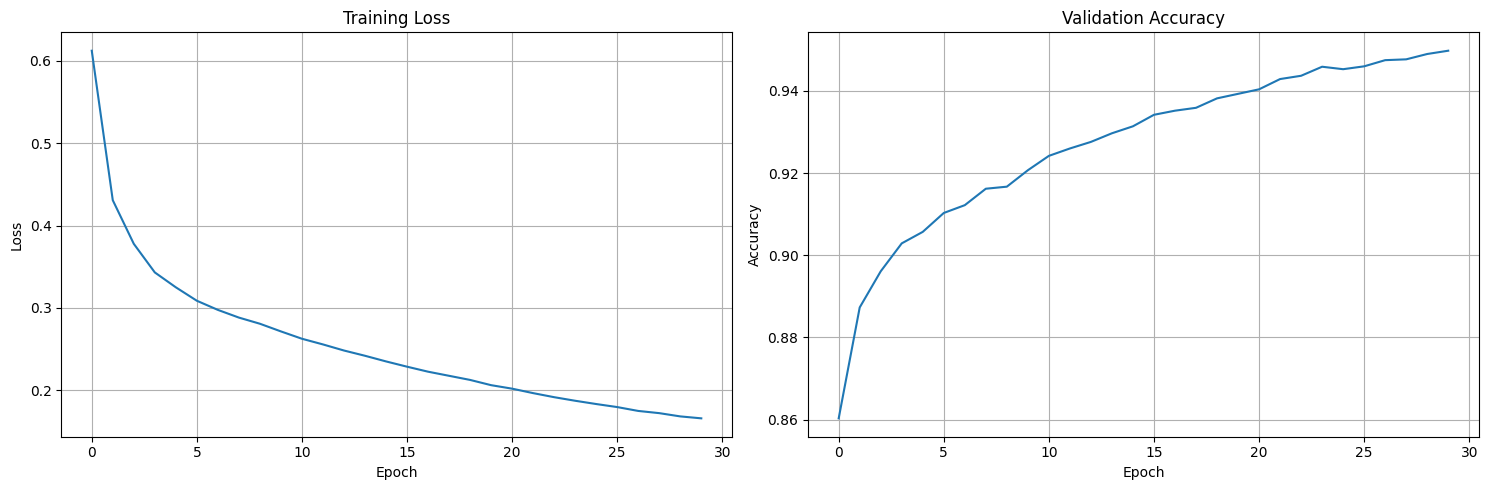

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(losses)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(val_accuracies)
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid(True)

plt.tight_layout()
plt.show()

Test accuracy: 0.9509


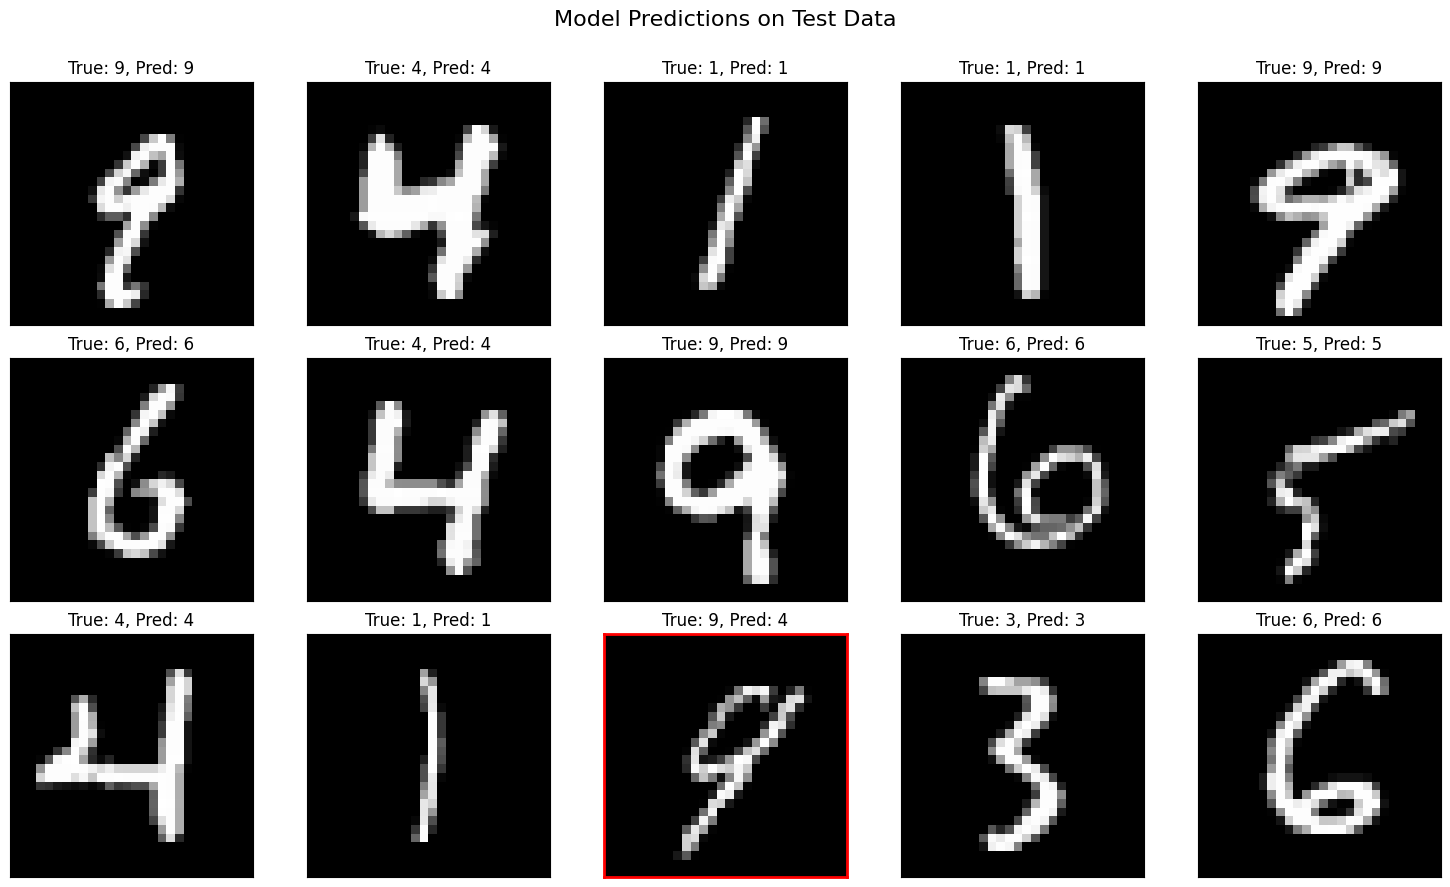

In [9]:
test_accuracy = nn.accuracy(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

test_predictions = nn.predict(X_test)

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Model Predictions on Test Data', fontsize=16)

for i, ax in enumerate(axes.flat):
    idx = i + np.random.randint(0, 100)
    true_label = np.argmax(y_test[idx])
    pred_label = test_predictions[idx]
    
    ax.imshow(test_images[idx], cmap='gray')
    ax.set_title(f"True: {true_label}, Pred: {pred_label}")
    ax.set_xticks([])
    ax.set_yticks([])
    if true_label != pred_label:
        plt.setp(ax.spines.values(), color='red', linewidth=2)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()